# Read Data

We are first reading in the SOTU.csv and setting it to 'sou'.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-dark') 

In [2]:
sou = pd.read_csv('data/SOTU.csv')
sou

,President,Year,Text,Word Count
0,Joseph R. Biden,2024.0,"\n[Before speaking, the President presented hi...",8003
1,Joseph R. Biden,2023.0,\nThe President. Mr. Speaker——\n[At this point...,8978
2,Joseph R. Biden,2022.0,"\nThe President. Thank you all very, very much...",7539
3,Joseph R. Biden,2021.0,\nThe President. Thank you. Thank you. Thank y...,7734
4,Donald J. Trump,2020.0,\nThe President. Thank you very much. Thank yo...,6169
...,...,...,...,...
241,George Washington,1791.0,\nFellow-Citizens of the Senate and House of R...,2264
242,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
243,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069
244,George Washington,1790.0,\nFellow-Citizens of the Senate and House of R...,1069


# Load en_core_web_sm

We also want to load in en_core_web_sm

In [3]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

# LDA:  
For this first part, we want to train an LDA model on our data. We preprocess our text, train the LDA model, and perform EDA.

# Load imports

In [4]:
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

/home/jovyan/.local/share/envs/sotu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocess the text

In [7]:
def preprocess_text(text): 
    doc = nlp(text) 
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space and len(token.lemma_) > 3]

processed_docs = sou['Text'].apply(preprocess_text)
print(processed_docs.head())

0    [speak, president, present, prepared, remark, ...
1    [president, speaker, point, president, turn, f...
2    [president, thank, thank, thank, madam, speake...
3    [president, thank, thank, thank, good, mitch, ...
4    [president, thank, thank, thank, madam, speake...
Name: Text, dtype: object


# Create a dictionary and corpus

In [8]:
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train the LDA model w/ 18 topics

In [9]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, random_state=42, passes=10)

# Print the top 10 words for each topic

In [10]:
lda_model.print_topics(-1)

[(0,
  '0.013*"states" + 0.013*"government" + 0.009*"united" + 0.008*"congress" + 0.007*"country" + 0.006*"year" + 0.006*"public" + 0.006*"great" + 0.005*"state" + 0.005*"power"'),
 (1,
  '0.002*"year" + 0.002*"people" + 0.002*"government" + 0.001*"states" + 0.001*"congress" + 0.001*"country" + 0.001*"nation" + 0.001*"great" + 0.001*"time" + 0.001*"united"'),
 (2,
  '0.003*"year" + 0.003*"government" + 0.002*"states" + 0.002*"congress" + 0.002*"united" + 0.002*"people" + 0.002*"great" + 0.002*"service" + 0.002*"public" + 0.001*"increase"'),
 (3,
  '0.015*"year" + 0.011*"world" + 0.011*"people" + 0.011*"america" + 0.010*"nation" + 0.007*"help" + 0.007*"congress" + 0.007*"american" + 0.007*"work" + 0.006*"time"'),
 (4,
  '0.009*"isthmus" + 0.006*"colombia" + 0.005*"government" + 0.004*"states" + 0.004*"panama" + 0.004*"united" + 0.004*"colombian" + 0.004*"treaty" + 0.003*"year" + 0.003*"congress"'),
 (5,
  '0.003*"year" + 0.002*"government" + 0.002*"nation" + 0.001*"united" + 0.001*"coun

For each of these topics, we see the top 10 words that are most highly associated with each topic. Each word in the topic is multiplied by a weight, which signifies it's contribution to the topic. Words that are more highly associated with a topic have higher weights.

# Print the topic distribution for the 1st speech

In [11]:
lda_model[corpus][0]

[(7, np.float32(0.9997309))]

Looking at the output, we see that the first speech has a ~99.97% chance of being associated with topic 7.

# Visualization

In [30]:
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [21]:
pyLDAvis.save_html(lda_display, 'outputs/lda.html')

# BERTopic:  
Next, we will train the BERTopic model on our dataset.

# Train the BERTopic model

In [13]:
docs = sou['Text'].to_list()

topic_model = BERTopic(min_topic_size=3)
topics, probs = topic_model.fit_transform(docs)

stop_words = CountVectorizer(stop_words='english')
topic_model.update_topics(docs, vectorizer_model=stop_words)

# Output top 10 words for each topic

In [18]:
# output the top 10 words for each topic - hint see get_topic_info
topic_model.get_topic_info()[['Topic', 'Representation']]

,Topic,Representation
0,-1,"[government, states, congress, united, people,..."
1,0,"[states, government, united, congress, public,..."
2,1,"[states, government, united, congress, public,..."
3,2,"[america, american, americans, jobs, tonight, ..."
4,3,"[world, new, president, american, america, peo..."
5,4,"[government, work, great, public, law, congres..."
6,5,"[states, government, congress, united, public,..."
7,6,"[world, soviet, nations, peace, war, nation, n..."
8,7,"[people, jobs, year, work, american, new, worl..."
9,8,"[government, law, states, gold, united, congre..."


We see the top 10 words with the greatest probability of being associated with each topic.

# Topic distribution for the 1st speech

In [22]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs)
grph = topic_model.visualize_distribution(topic_distr[0])
grph

In [29]:
grph.write_html("outputs/topic_prob_distr.html")

We see that the first speech has around a 17% chance of being about topic 2 and around a 10% chance of being about topics 3, 7, 10, 16, and 20. This is interesting as from the LDA model, we saw the first speech has having a 99.97% chance of being about topic 7. The LDA model was extremely confident that the 1st speech was associated with topic 7 but compared to the results of the BERTopic model, the BERTopic model is pretty split between ~6 topics. 

# Visualization

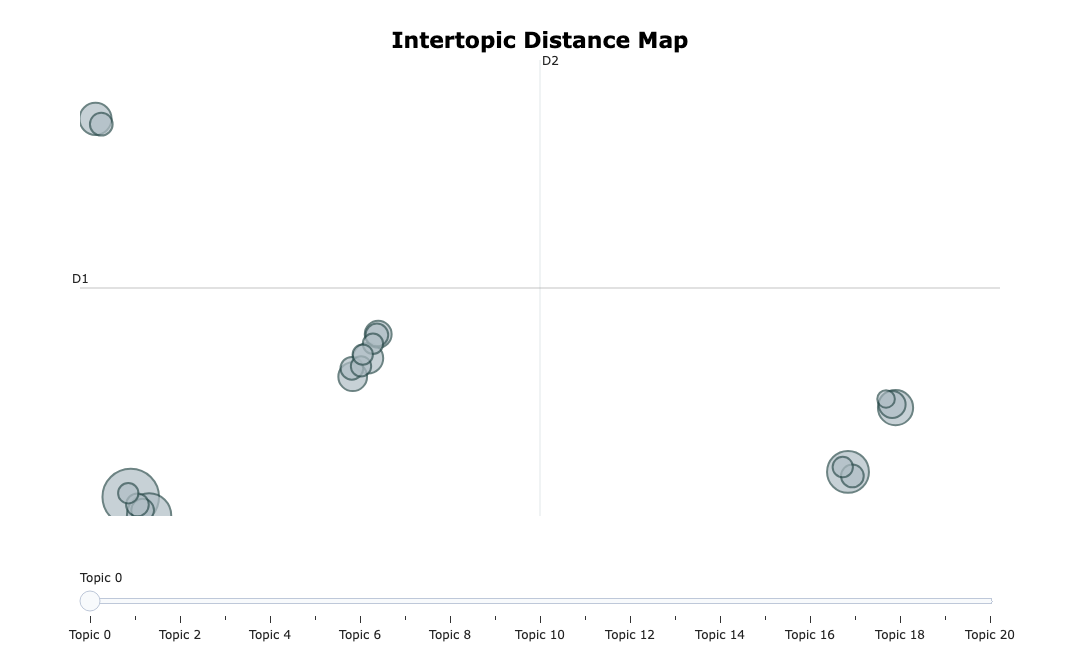

In [26]:
# run this cell to visualize the topics
grph2 = topic_model.visualize_topics()
grph2

In [31]:
grph2.write_html("outputs/intertopic_distance_map.html")